# Random Forests

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn.apionly as sns
sns.set_style("whitegrid")
sns.set_context("poster")

/opt/conda/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/conda/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/opt/conda/lib/python3.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


## Dataset

First, the data. We will be attempting to predict the presidential election results (at the county level) from 2016, measured as 'votergap' = (trump - clinton) in percentage points, based mostly on demographic features of those counties.  Let's quick take a peak at the data:

In [2]:
elect_df = pd.read_csv("data/county_level_election.csv")
elect_df.head()

,state,fipscode,county,population,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,cancer,votergap,trump,clinton
0,Colorado,8117,Summit County,27239,15.173,4.918,45.996,2.5,68352,5.4,48.1,8.1,13.1,46.0,46.2,-27.632,31.530,59.162
1,Colorado,8037,Eagle County,53653,30.040,5.169,47.231,3.1,76661,10.1,47.3,9.4,11.8,31.0,47.1,-19.897,36.058,55.955
2,Idaho,16067,Minidoka County,19226,34.070,5.611,49.318,3.7,46332,24.1,11.8,18.3,34.2,80.0,61.8,54.148,71.135,16.987
3,Colorado,8113,San Miguel County,7558,10.154,4.747,46.808,3.7,59603,4.7,54.4,12.4,16.7,5.7,62.6,-44.769,23.892,68.662
4,Utah,49051,Wasatch County,21600,13.244,4.125,48.812,3.4,65207,9.5,34.4,13.9,23.0,257.8,68.3,25.357,50.471,25.114


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# split 80/20 train-test
Xdf = elect_df[['population','hispanic','minority','female','unemployed','income','nodegree','bachelor','inactivity','obesity','density','cancer']]
response = elect_df['votergap']
Xtraindf, Xtestdf, ytrain, ytest = train_test_split(Xdf, response, test_size=0.2, random_state=1983)


## Random Forests

What's the basic idea?

Bagging alone is not enough randomization, because even after bootstrapping, we are mainly training on the same data points using the same variablesn, and will retain much of the overfitting.

So we will build each tree by splitting on "random" subset of predictors at each split (hence, each is a 'random tree').  This can't be done in with just one predcitor, but with more predictors we can choose what predictors to split on randomly and how many to do this on.  Then we combine many 'random trees' together by averaging their predictions, and this gets us a forest of random trees: a **random forest**.

Below we create a hyper-param Grid. We are preparing to use the bootstrap points not used in training for validation.

```
max_features : int, float, string or None, optional (default=”auto”)
- The number of features to consider when looking for the best split.
```

- `max_features`: Default splits on all the features and is probably prone to overfitting. You'll want to validate on this. 
- You can "validate" on the trees `n_estimators` as well but many a times you will just look for the plateau in the trees as seen below.
- From decision trees you get the `max_depth`, `min_samples_split`, and `min_samples_leaf` as well but you could leave those at defaults to get a maximally expanded tree as adding multiple trees will squeeze out the variance.

In [5]:
from sklearn.ensemble import RandomForestRegressor

We'll use itertools product to simulare what the param-grid in cross-validate does for us.

In [6]:
# code from 
# Adventures in scikit-learn's Random Forest by Gregory Saunders
from itertools import product
from collections import OrderedDict
param_dict = OrderedDict(
    n_estimators = [400, 600, 800],
    max_features = [0.2, 0.4, 0.6, 0.8]
)

param_dict.values()

list(product(*param_dict.values()))

[(400, 0.2),
 (400, 0.4),
 (400, 0.6),
 (400, 0.8),
 (600, 0.2),
 (600, 0.4),
 (600, 0.6),
 (600, 0.8),
 (800, 0.2),
 (800, 0.4),
 (800, 0.6),
 (800, 0.8)]

### Using the OOB score.

Why did we play with `itertools.product`?

We have been putting "validate" in quotes. This is because the bootstrap gives us left-over points! So we'll now engage in our very own version of a grid-search, done over the out-of-bag scores that `sklearn` gives us for free

EXERCISE

With the "validation" based on left out samples from the bootstrap, cross-validate and find the 

In [20]:
#make sure ytrain is the correct data type...in case you have warnings
#print(yytrain.shape,ytrain.shape,Xtrain.shape)
#ytrain = np.ravel(ytrain)

#Let's Cross-val. on the two 'hyperparameters' we based our grid on earlier
results = {}
estimators= {}
for ntrees, maxf in product(*param_dict.values()):
    params = (ntrees, maxf)
    est = RandomForestRegressor(oob_score=True, 
                                n_estimators=ntrees, max_features=maxf, max_depth=50, n_jobs=-1)
    est.fit(Xtraindf, ytrain)
    results[params] = est.oob_score_
    estimators[params] = est
outparams = max(results, key = results.get)
outparams

(800, 0.6)

In [21]:
rf1 = estimators[outparams]

In [22]:
results

{(400, 0.2): 0.7518802987961095,
 (400, 0.4): 0.7728046245766584,
 (400, 0.6): 0.7760031367158795,
 (400, 0.8): 0.7759400616791148,
 (600, 0.2): 0.7520380388978598,
 (600, 0.4): 0.771736002159674,
 (600, 0.6): 0.7766844152890818,
 (600, 0.8): 0.7772248554747541,
 (800, 0.2): 0.7547633037110385,
 (800, 0.4): 0.7724459979968716,
 (800, 0.6): 0.7785483491987532,
 (800, 0.8): 0.7780888224028408}

In [23]:
rf1.score(Xtestdf, ytest)

0.7541466569144869

Finally you can find the **feature importance** of each predictor in this random forest model. Whenever a feature is used in a tree in the forest, the algorithm will log the decrease in the splitting criterion (such as gini). This is accumulated over all trees and reported in `est.feature_importances_`

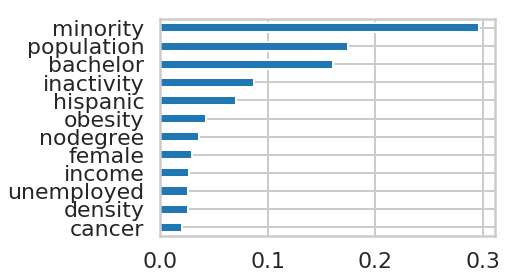

In [24]:
pd.Series(rf1.feature_importances_,index=list(Xtraindf)).sort_values().plot(kind="barh");

Since our response isn't very symmetric, we may want to suppress outliers by using the `mean_absolute_error` instead. 

Note: instead of using oob scoring, we could do cross-validation (with GridSearchCV), and a cv of 3 will roughly be comparable (same approximate train-vs.-validation set sizes). But this will take much more time as you are doing the fit 3 times plus the bootstraps. So at least three times as long!

### Exercise

1. What are the 3 *hyperparameters* for a random forest (one of the hyperparameters come in many *flavors*)?
2. Which hyperparameters need to be tuned? 

**Answers**
1. The 3 hyperparameters are `max_features`,  `max_depth` (or something related, like `min_samples_split`, so control the complexity of each tree), and `n_estimators` (in classification, the splitting criteria is another one you could consider)

2. `max_features` and  `max_depth` need to be tuned, while the higher `n_estimators` the better (though there is clearly diminishing return, so just use someting 'largish' in the hundreds).  The best tuned `max_features` and `max_depth` will depend on the number of predictors you are considering, the number of observations in the training set, and whether it is a regression or a classification problem.  There are lots of rules of thumb out there, but cross-validate if you can.

### Seeing error as a function of the proportion of predictors at each split

Let's look to see how `max_features` affects performance on the training set.

In [25]:
# from http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

feats = param_dict['max_features']
# 
error_rate = OrderedDict((label, []) for label in feats)

# Range of `n_estimators` values to explore.
min_estimators = 200
step_estimators = 100
num_steps = 6
max_estimators = min_estimators + step_estimators*num_steps
for label in feats:
    for i in range(min_estimators, max_estimators+1, step_estimators):
        clf = RandomForestRegressor(oob_score=True, max_features=label)
        clf.set_params(n_estimators=i)
        clf.fit(Xtraindf, ytrain)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

In [26]:
print(feats)

[0.2, 0.4, 0.6, 0.8]


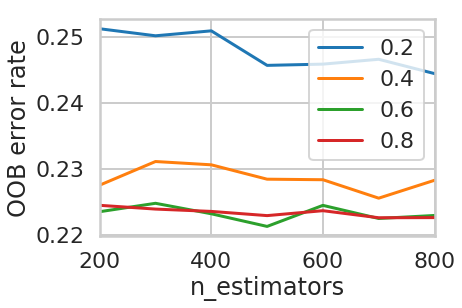

In [27]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

---